# Discovery notebook for cycling crash data

Crash data from 2016 to 2023.

This data came from the Louisville Open Data portal

Source: https://data.louisvilleky.gov/datasets/

LOJIC::louisville-metro-ky-traffic-fatalities-and-suspected-serious-injuries-1/explore

Shape: 4901 rows x 44 columns


## LOJIC data dictionary

| column name | type | description | value notes | cleaning notes | 
|-------------|------|-------------|-------------|----------------|
| X | number | X dimension of a geographic coordinate for crash | longitude | redundant; drop|
| Y | number | Y dimention of a geographic coordinate for crash | latitude | redundant; drop| 
| IncidentID | number | |||
| AgencyName | string | |||
| RdwyNumber | alphanumeric ||||
| Street | number ||||
| StreetDir | string |||| 
| RoadwayName | string | |||
| StreetSfx | string | |||
| OWNER | string | |||
| ROAD_CLASSIFICATION | string ||||
| COUNCIL_DISTRICT | number ||||
| IntersectionRdwy | ||||
| IntersectionRdwyName |||||
| BetweenStRdwy1 |||||
| BetweenStRdwyName1 |||||
| BetweenStRdwy2 |||||
| BetweenStRdwyName2 |||||
| Latitude | float | Latitude coordinate for crash || ==Y; keep this; discard Y|
| Longitude |float | Longitude coordinate for crash || ==X; keep this; discard X|
| Milepoint | float | Milepoint along road where crash occurred || useful for highways?|
| DAY_OF_WEEK | string | Day of week crash occrred | MONDAY, TUESDAY, etc.| redundant? Can be derived from date data|
| CollisionDate | alphanumeric | date/time crash occurred | YYYY/MM/DD HH:MM:SS+milliseconds | parse and compare with other time info: It doesn't match, see notebook. Date in in GMT/UTC time; information needs to be updated to EST|
| CollisionTime |number | Time of crash | integer representation of crash time. Ex. 2:30 PM == 1430.0| keep for validation during cleaning, then drop |
| HOUR_OF_DAY | alphanumeric | Time of day crash occurred | hour + AM/PM | redundant? Can be drived from other time data. |
| UnitsInvolved | number | count of vehicles involved || keep |
| MotorVehiclesInvolved | number | count of motor vehicles involved || keep |
| MODE | string | type of vehicle crash| motor vehicle, bicycle, pedestrian, etc. | Drop rows that don't have bicycle data.|
| NAME | string | Name of crash victim || drop |
| AGE |number | age of crash victim || drop |
| GENDER | string| gender of crash victim||drop|
| SEVERITY |string | Boolean indicator: were people killed or injured in crash| SUSPECTED INJURY or FATALITY| find a way to make this work with the other dataset|
| LINK | string | Link to news article about the crash || drop |
| Weather |||||
| RdwyConditionCode |||||
| HitandRun |boolean | Was the crash a hit and run? || nothing to do; keep|
| DirAnalysisCode |||||
| MannerofCollision |||||
| RdwyCharacter |||||
| LightCondition |||||
| RampFromRdwyId |||||
| RampToRdwyId |||||
| IsSecondaryCollision | boolean | Was the crash a secondary collision? || nothing to do; keep |
| ObjectId |number | unique identifier for row | | ? |


## Exploring LOJIC data

In [119]:
import pandas as pd
import pyparsing as pyp
import matplotlib
from datetime import datetime, timedelta, time
from math import isnan

DATA = "../data/raw/Louisville_Metro_KY_-_Traffic_Fatalities_and_Suspected_Serious_Injuries.csv"
df = pd.read_csv(DATA)


In [120]:
df

,X,Y,IncidentID,AgencyName,RdwyNumber,Street,StreetDir,RoadwayName,StreetSfx,OWNER,...,RdwyConditionCode,HitandRun,DirAnalysisCode,MannerofCollision,RdwyCharacter,LightCondition,RampFromRdwyId,RampToRdwyId,IsSecondaryCollision,ObjectId
0,-85.866176,38.108531,17498513,LOUISVILLE METRO POLICE DEPT,US0031W,NaN,NaN,DIXIE,HWY,STATE,...,DRY,False,ANGLE COLLISION - BOTH VEHICLES GOING STRAIGHT,ANGLE,CURVE & GRADE,DAYLIGHT,NaN,NaN,False,1
1,-85.764908,38.191179,17493656,LOUISVILLE METRO POLICE DEPT,NaN,NaN,S,3RD,ST,METRO,...,DRY,True,COLLISION WITH PEDESTRIAN NON - INTERSECTION,SINGLE VEHICLE,STRAIGHT & LEVEL,DARK-HWY NOT LIGHTED,NaN,NaN,False,2
2,-85.599441,38.264198,17493944,LOUISVILLE METRO POLICE DEPT,NaN,NaN,NaN,LA GRANGE,RD,METRO,...,DRY,False,OPPOSITE DIRECTION - BOTH VEHICLES GOING STRAI...,HEAD ON,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON,NaN,NaN,False,3
3,-85.822601,38.217082,17493960,LOUISVILLE METRO POLICE DEPT,I 0264,NaN,NaN,I-264,NaN,FEDERAL,...,DRY,False,OTHER COLLISIONS ON SHOULDER,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT,NaN,NaN,False,4
4,-85.822601,38.217082,17493960,LOUISVILLE METRO POLICE DEPT,I 0264,NaN,NaN,I-264,NaN,FEDERAL,...,DRY,False,OTHER COLLISIONS ON SHOULDER,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT,NaN,NaN,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4947,-85.694752,38.248721,30385868,LOUISVILLE METRO POLICE DEPT,NaN,NaN,S,GALT,AVE,METRO,...,DRY,False,COLLISION WITH PEDESTRIAN IN INTERSECTION,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT,NaN,NaN,False,4948
4948,-85.719290,38.134872,30784583,LOUISVILLE METRO POLICE DEPT,KY1065,NaN,NaN,OUTER,LOOP,STATE,...,DRY,False,ANGLE COLLISION - ONE VEHICLE TURNING LEFT,ANGLE,STRAIGHT & LEVEL,DAWN,NaN,NaN,False,4949
4949,-85.718422,38.191084,30822329,LOUISVILLE METRO POLICE DEPT,I 0264,NaN,NaN,I-264,NaN,FEDERAL,...,DRY,False,1 VEHICLE PARKED POSITION (NOT PARKING LOT/DRI...,REAR END,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON,NaN,NaN,False,4950
4950,-85.535367,38.317549,30789702,LOUISVILLE METRO POLICE DEPT,KY0022,NaN,NaN,BALLARDSVILLE,RD,STATE,...,DRY,False,OTHER COLLISIONS ON SHOULDER,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT,NaN,NaN,False,4951


Column names can be organized into groups of related data.

### Geolocation
['X', 'Y',  'Latitude', 'Longitude']

### Police/authorities info
['IncidentID', 'AgencyName']

### Address/location information
['RdwyNumber', 'Street', 'StreetDir', 'RoadwayName', 'StreetSfx',
'IntersectionRdwy', 'IntersectionRdwyName',
'BetweenStRdwy1', 'BetweenStRdwyName1', 'BetweenStRdwy2', 'BetweenStRdwyName2', 
'RampFromRdwyId', 'RampToRdwyId', 
'Milepoint']

### Other road information
['OWNER', 'ROAD_CLASSIFICATION', 'RdwyCharacter']

### Time data
['DAY_OF_WEEK', 'CollisionDate', 'CollisionTime', 'HOUR_OF_DAY']

### Accident report information
['UnitsInvolved', 'MotorVehiclesInvolved', 'MODE', 'NAME', 'AGE',
'GENDER', 'SEVERITY', 'LINK', 'HitandRun', 'DirAnalysisCode', 'MannerofCollision',        'IsSecondaryCollision']


### Road/weather/light conditions       
['Weather', 'RdwyConditionCode', 'LightCondition']

### Other data
['COUNCIL_DISTRICT', 'ObjectId', ]

# Columns

#### Geolocation columns

In [121]:
df[['X', 'Y', 'Latitude', 'Longitude',]]
df[df['X'] != df['Longitude']]
# Returns empty dataframe. All records match
df[df['Y'] != df['Latitude']]
# Also empty
# X == Longitude and Y == Latitude
# Dropping X, Y, keeping Longitude, Latitude


,X,Y,IncidentID,AgencyName,RdwyNumber,Street,StreetDir,RoadwayName,StreetSfx,OWNER,...,RdwyConditionCode,HitandRun,DirAnalysisCode,MannerofCollision,RdwyCharacter,LightCondition,RampFromRdwyId,RampToRdwyId,IsSecondaryCollision,ObjectId


In [122]:
# Identifying number for crash case
ID = df['IncidentID']
ID.info()
len(ID.unique())
# Not all IDs are unique!



<class 'pandas.core.series.Series'>
RangeIndex: 4952 entries, 0 to 4951
Series name: IncidentID
Non-Null Count  Dtype
--------------  -----
4952 non-null   int64
dtypes: int64(1)
memory usage: 38.8 KB


4315

<Axes: ylabel='COUNCIL_DISTRICT'>

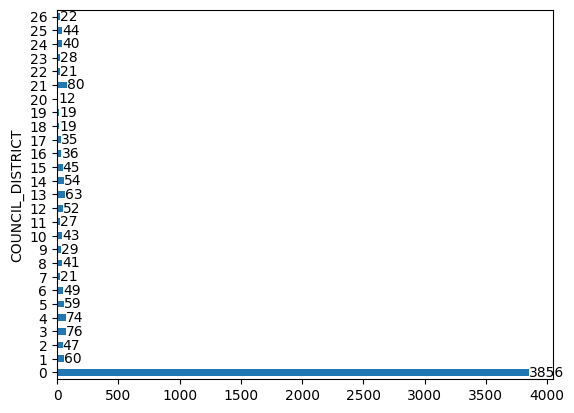

In [123]:


# Metro council district where crash occurred
CD = df['COUNCIL_DISTRICT']
CD.unique()
values = CD.value_counts().sort_index()
values = values.sort_index()
ax = values.plot(kind = 'barh')
ax.bar_label(ax.containers[0])
ax


### Address columns

In [124]:
# Main roadway information
df[['RdwyNumber', 'Street', 'StreetDir', 'RoadwayName', 'StreetSfx']]

,RdwyNumber,Street,StreetDir,RoadwayName,StreetSfx
0,US0031W,NaN,NaN,DIXIE,HWY
1,NaN,NaN,S,3RD,ST
2,NaN,NaN,NaN,LA GRANGE,RD
3,I 0264,NaN,NaN,I-264,NaN
4,I 0264,NaN,NaN,I-264,NaN
...,...,...,...,...,...
4947,NaN,NaN,S,GALT,AVE
4948,KY1065,NaN,NaN,OUTER,LOOP
4949,I 0264,NaN,NaN,I-264,NaN
4950,KY0022,NaN,NaN,BALLARDSVILLE,RD


In [125]:

# Intersection info
df[['IntersectionRdwy', 'IntersectionRdwyName']]
# Similar to other data


,IntersectionRdwy,IntersectionRdwyName
0,NaN,NaN
1,KY2801,FLORENCE
2,NaN,ORMSBY
3,NaN,NaN
4,NaN,NaN
...,...,...
4947,NaN,GRINSTEAD
4948,NaN,AIR COMMERCE
4949,NaN,NaN
4950,NaN,NaN


In [126]:

# Between streets info
df[['BetweenStRdwy1', 'BetweenStRdwyName1', 'BetweenStRdwy2', 'BetweenStRdwyName2']]
# Similar to other data and similar to main road report


,BetweenStRdwy1,BetweenStRdwyName1,BetweenStRdwy2,BetweenStRdwyName2
0,NaN,ALANADALE,KY0907,VALLEY STATION
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
4947,NaN,NaN,NaN,NaN
4948,NaN,NaN,NaN,NaN
4949,NaN,NaN,NaN,NaN
4950,NaN,NaN,NaN,NaN


In [127]:

df['Milepoint']
# Is this useful for highway accidents?

0        8.702
1        0.650
2        0.432
3        4.411
4        4.411
         ...  
4947     0.419
4948     4.223
4949    12.700
4950     6.269
4951     4.201
Name: Milepoint, Length: 4952, dtype: float64

### Time/date columns

In [150]:

times = df[['IncidentID','DAY_OF_WEEK', 'HOUR_OF_DAY', 'CollisionDate', 'CollisionTime']]
# Parse out CollisionDate 
# Check times against HOUR_OF_DAY
# Derive day of the week and check?
times.info()
##! CollistionTime has some null values!
times

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4952 entries, 0 to 4951
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   IncidentID     4952 non-null   int64  
 1   DAY_OF_WEEK    4952 non-null   object 
 2   HOUR_OF_DAY    4952 non-null   object 
 3   CollisionDate  4952 non-null   object 
 4   CollisionTime  4947 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 193.6+ KB


,IncidentID,DAY_OF_WEEK,HOUR_OF_DAY,CollisionDate,CollisionTime
0,17498513,FRIDAY,2AM,2016/01/01 07:50:00+00,250.0
1,17493656,FRIDAY,3PM,2016/01/01 20:14:00+00,1514.0
2,17493944,FRIDAY,6PM,2016/01/01 23:14:00+00,1814.0
3,17493960,SATURDAY,10AM,2016/01/02 15:55:00+00,1055.0
4,17493960,SATURDAY,10AM,2016/01/02 15:55:00+00,1055.0
...,...,...,...,...,...
4947,30385868,WEDNESDAY,8AM,2022/08/03 12:26:00+00,826.0
4948,30784583,FRIDAY,7AM,2022/11/04 11:55:00+00,755.0
4949,30822329,SUNDAY,4AM,2022/11/06 09:00:00+00,400.0
4950,30789702,MONDAY,2PM,2022/11/07 19:57:00+00,1457.0


Collision date time and CollisionTime don't seem to match; they should. This appears to be some error in the CSV generated by LOJIC on the Louisville Open Data portal. On the online viewer the time and date all line up. Very strange. The CollisionTime column appears to be correct. With the day of the week info I should be able to derive the correct date and time. 

In [129]:
# Bringing in pyparsing to parse CollisionDate
integer = pyp.Word(pyp.nums).set_name("integer")
# Define integer word: a string of numeric characters 0-9

date_expr = integer("year") + '/' + integer("month") + '/' + integer('day')
time_expr = (integer("hour") + ":" + integer("minute") +
              (pyp.Literal(":") + integer("second") + "+" + integer("ms")).suppress())

CollisionDate_expr = date_expr + time_expr

def get_CD_string(location):
    return times.iloc[location]['CollisionDate']


def parse_CD(string):
    out = CollisionDate_expr.parse_string(string).as_dict()
    return {K:int(V) for K, V in out.items()}


In [130]:
# Testing parsing code
location = 2338 # <- Change int value to test different rows
test = get_CD_string(location) 
print(test)
parse_CD(test)


2020/06/14 04:00:00+00


{'year': 2020, 'month': 6, 'day': 14, 'hour': 4, 'minute': 0}

In [131]:
# Parsing ColisionTime column
CT = df['CollisionTime']
CT.info()
CT.agg(("max", "min", "median"))
# Normal time range from 0 (midnight) to 23:59

<class 'pandas.core.series.Series'>
RangeIndex: 4952 entries, 0 to 4951
Series name: CollisionTime
Non-Null Count  Dtype  
--------------  -----  
4947 non-null   float64
dtypes: float64(1)
memory usage: 38.8 KB


max       2359.0
min          0.0
median    1532.0
Name: CollisionTime, dtype: float64

In [151]:
times[times['CollisionTime'] == 0]
# 0 value for time doesn't appear to be a problem. It indicates midnight.
# These records have the correct time in the time part of the CollisionDate column,
# when I checked them on the LOJIC portal online


,IncidentID,DAY_OF_WEEK,HOUR_OF_DAY,CollisionDate,CollisionTime
1995,24414008,THURSDAY,12AM,2018/12/20 05:00:00+00,0.0
1996,24414008,THURSDAY,12AM,2018/12/20 05:00:00+00,0.0


In [152]:
times[CT.isnull()]
# Rows where CollisionTime is null. Probably have to discard these.


,IncidentID,DAY_OF_WEEK,HOUR_OF_DAY,CollisionDate,CollisionTime
2338,26821101,SUNDAY,UNKNOWN,2020/06/14 04:00:00+00,NaN
2978,27274152,SUNDAY,UNKNOWN,2020/08/23 04:00:00+00,NaN
3593,28652585,SATURDAY,UNKNOWN,2021/09/11 04:00:00+00,NaN
3595,27985631,THURSDAY,UNKNOWN,2021/04/08 04:00:00+00,NaN
4145,31542554,TUESDAY,UNKNOWN,2023/04/25 04:00:00+00,NaN


In [134]:
from math import isnan

cast = lambda x:(isnan(x) and x) or int(x)
# x if isnan(x) else int(x)

def parse_CollisionTime(time):
    minutes = cast(time%100)
    hours = cast(time // 100)
    return {'CThour':hours, 'CTminute':minutes}

parse_CollisionTime(11.0)


{'CThour': 0, 'CTminute': 11}

In [135]:
location = 2336 # <- Change to test different values.
    # To test code dealing with nan's: location = 2338
test = times.iloc[location]['CollisionTime']
print(test)
parse_CollisionTime(test)

122.0


{'CThour': 1, 'CTminute': 22}

In [137]:
# How to get day of the week from datetime
datetime.now().strftime("%A")


'Sunday'

In [153]:
# Get CollisionDate and CollisionTime parsed and in a dataframe
times

,IncidentID,DAY_OF_WEEK,HOUR_OF_DAY,CollisionDate,CollisionTime
0,17498513,FRIDAY,2AM,2016/01/01 07:50:00+00,250.0
1,17493656,FRIDAY,3PM,2016/01/01 20:14:00+00,1514.0
2,17493944,FRIDAY,6PM,2016/01/01 23:14:00+00,1814.0
3,17493960,SATURDAY,10AM,2016/01/02 15:55:00+00,1055.0
4,17493960,SATURDAY,10AM,2016/01/02 15:55:00+00,1055.0
...,...,...,...,...,...
4947,30385868,WEDNESDAY,8AM,2022/08/03 12:26:00+00,826.0
4948,30784583,FRIDAY,7AM,2022/11/04 11:55:00+00,755.0
4949,30822329,SUNDAY,4AM,2022/11/06 09:00:00+00,400.0
4950,30789702,MONDAY,2PM,2022/11/07 19:57:00+00,1457.0


In [139]:
def get_row(location):
    CT = times.iloc[location]['CollisionTime']
    CD = times.iloc[location]['CollisionDate']

    HM = parse_CollisionTime(CT)
    DATE = parse_CD(CD)
    return HM | DATE

parsed = get_row(2338)
parsed


{'CThour': nan,
 'CTminute': nan,
 'year': 2020,
 'month': 6,
 'day': 14,
 'hour': 4,
 'minute': 0}

In [140]:

def get_datetimes(location):
    P = get_row(location)
    # print(location) # 2338 is the probelm
    raw_datetime = datetime(day=P['day'], month=P['month'], year=P['year'],
                            hour=P['hour'], minute=P['minute'])
    derived_datetime = datetime(day=P['day'], month=P['month'], year=P['year'],
                                hour=P['CThour'], minute=P['CTminute'])
    return raw_datetime, derived_datetime
    

def get_datetime_diff(location):
    try:
        raw, CT = get_datetimes(location)
    except TypeError:
        return float('nan')
    else:
        return raw-CT
    
def get_time_diff(location):
    P = get_row(location)
    rawtime = timedelta(hours=P['hour'], minutes=P['minute'])
    try:
        CTtime = timedelta(hours=P['CThour'], minutes=P['CTminute'])
    except ValueError:
        return float('nan')
    else:
        return rawtime - CTtime
    

test_loc = 2338
print(get_datetime_diff(test_loc))
print(get_time_diff(test_loc))



    

nan
nan


In [180]:
def get_dt_diffs(df):   
    diffs = list()
    for loc in range(len(df)):
        diffs.append(get_datetime_diff(loc))
    return pd.Series(diffs, name='dt_diffs')

dt_diffs = get_dt_diffs(times)
dt_diffs.value_counts()

dt_diffs
0 days 04:00:00      2651
0 days 05:00:00      1078
-1 days +04:00:00     827
-1 days +05:00:00     389
0 days 04:02:00         1
-1 days +04:53:00       1
Name: count, dtype: int64

In [183]:
def get_t_diffs(df):
    diffs = list()
    for loc in range(len(df)):
        diffs.append(get_time_diff(loc))
    return pd.Series(diffs, name='t_diffs')

t_diffs = get_t_diffs(times)
t_diffs.value_counts(dropna=False)

t_diffs
0 days 04:00:00      2651
0 days 05:00:00      1078
-1 days +04:00:00     827
-1 days +05:00:00     389
NaT                     5
0 days 04:02:00         1
-1 days +04:53:00       1
Name: count, dtype: int64

In [188]:
def make_difftable(df):
    return pd.concat((df, get_dt_diffs(df), get_t_diffs(df)), axis = 1)

difftable = make_difftable(times)
difftable[['IncidentID', 'CollisionDate',	'CollisionTime', 't_diffs',	'dt_diffs']]

,IncidentID,CollisionDate,CollisionTime,t_diffs,dt_diffs
0,17498513,2016/01/01 07:50:00+00,250.0,0 days 05:00:00,0 days 05:00:00
1,17493656,2016/01/01 20:14:00+00,1514.0,0 days 05:00:00,0 days 05:00:00
2,17493944,2016/01/01 23:14:00+00,1814.0,0 days 05:00:00,0 days 05:00:00
3,17493960,2016/01/02 15:55:00+00,1055.0,0 days 05:00:00,0 days 05:00:00
4,17493960,2016/01/02 15:55:00+00,1055.0,0 days 05:00:00,0 days 05:00:00
...,...,...,...,...,...
4947,30385868,2022/08/03 12:26:00+00,826.0,0 days 04:00:00,0 days 04:00:00
4948,30784583,2022/11/04 11:55:00+00,755.0,0 days 04:00:00,0 days 04:00:00
4949,30822329,2022/11/06 09:00:00+00,400.0,0 days 05:00:00,0 days 05:00:00
4950,30789702,2022/11/07 19:57:00+00,1457.0,0 days 05:00:00,0 days 05:00:00


The differences in time are not consistent. 
My guess is that this has to do with time zone conversions.
Times in dataset are supposed to be given in Eastern Standard Time, which is
GMT-5 in the summer and GMT-4 during daylight saving time. 

Conclusion: I'm going to update the CollisionDate value with the information from CollisionTime
This adjustment might interact with the DAY_OF_WEEK column. 


In [233]:
from datetime import timezone
import pytz
raw, adjusted = get_datetimes(1)
raw.replace(tzinfo=timezone.utc).astimezone(tz=pytz.timezone("US/Eastern")), adjusted

def adjust_tz(dt:datetime):
    try:
        out = dt.replace(tzinfo=timezone.utc).astimezone(tz=pytz.timezone("US/Eastern")) # Figure out more about this timezone 
#TODO Set to EST regardless of locale!
    except TypeError:
        return float('nan')
    else:
        return out
    

raw, adjust_tz(raw), adjusted


(datetime.datetime(2016, 1, 1, 20, 14),
 datetime.datetime(2016, 1, 1, 15, 14, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
 datetime.datetime(2016, 1, 1, 15, 14))

In [234]:
A = times['CollisionDate'].apply(parse_CD).to_list()
AT = pd.Series([adjust_tz(datetime(**X)) for X in A], name="AdjustedCD")
Atimes = pd.DataFrame(times)
Atimes['AdjustedDate'] = AT
Atimes
#make_difftable(Atimes)['t_diffs'].value_counts()

,IncidentID,DAY_OF_WEEK,HOUR_OF_DAY,CollisionDate,CollisionTime,AdjustedDate
0,17498513,FRIDAY,2AM,2016/01/01 07:50:00+00,250.0,2016-01-01 02:50:00-05:00
1,17493656,FRIDAY,3PM,2016/01/01 20:14:00+00,1514.0,2016-01-01 15:14:00-05:00
2,17493944,FRIDAY,6PM,2016/01/01 23:14:00+00,1814.0,2016-01-01 18:14:00-05:00
3,17493960,SATURDAY,10AM,2016/01/02 15:55:00+00,1055.0,2016-01-02 10:55:00-05:00
4,17493960,SATURDAY,10AM,2016/01/02 15:55:00+00,1055.0,2016-01-02 10:55:00-05:00
...,...,...,...,...,...,...
4947,30385868,WEDNESDAY,8AM,2022/08/03 12:26:00+00,826.0,2022-08-03 08:26:00-04:00
4948,30784583,FRIDAY,7AM,2022/11/04 11:55:00+00,755.0,2022-11-04 07:55:00-04:00
4949,30822329,SUNDAY,4AM,2022/11/06 09:00:00+00,400.0,2022-11-06 04:00:00-05:00
4950,30789702,MONDAY,2PM,2022/11/07 19:57:00+00,1457.0,2022-11-07 14:57:00-05:00


In [235]:
def test_adjustment(loc):
    row = Atimes.iloc[101]
    CT = parse_CollisionTime(row['CollisionTime'])
    date = row['AdjustedDate']
    assert date.hour == CT['CThour']
    assert date.minute == CT['CTminute']

    dow = date.strftime("%A").upper()
    assert dow == row['DAY_OF_WEEK']
    return True

all(test_adjustment(n) for n in range(len(Atimes)))
#test_adjustment(2338)
#Atimes.iloc[2338]
# All tests pass! Time zone adjustment fixes my data mismatches.
# After doing this step, I can use the new adjusted date field to get all my time/date data

True

### Units involved columns

<Axes: xlabel='UnitsInvolved'>

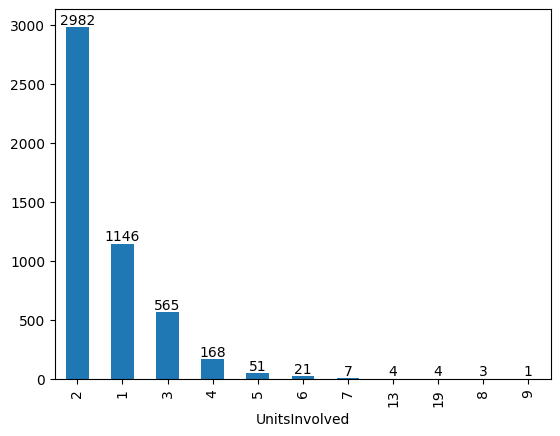

In [236]:
# Number of vehicles involves and # of motor vehicles.
ax = df['UnitsInvolved'].value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0])
ax


<Axes: xlabel='MotorVehiclesInvolved'>

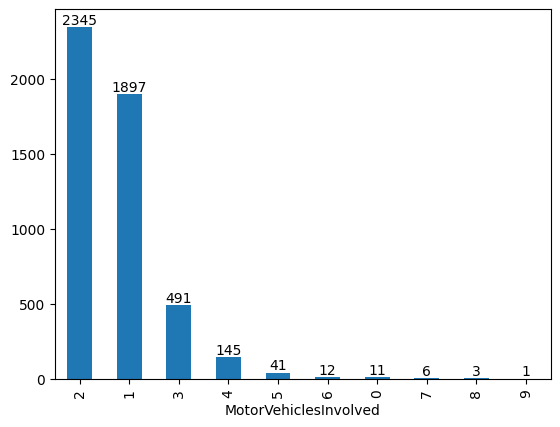

In [237]:
ax = df['MotorVehiclesInvolved'].value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0])
ax


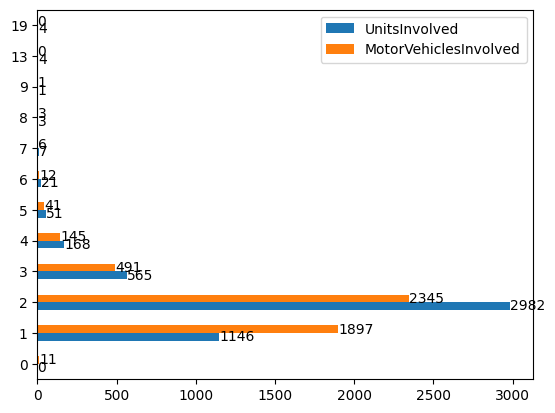

In [238]:
units = df[['UnitsInvolved', 'MotorVehiclesInvolved']]
ax = units.apply(lambda x : x.value_counts()).plot(kind='barh')
for container in ax.containers:
    ax.bar_label(container)

In [243]:
# Object Id column
df['ObjectId'].info()
len(df['ObjectId'].unique())
# Unique identifier for row. 




<class 'pandas.core.series.Series'>
RangeIndex: 4952 entries, 0 to 4951
Series name: ObjectId
Non-Null Count  Dtype
--------------  -----
4952 non-null   int64
dtypes: int64(1)
memory usage: 38.8 KB


4952

In [244]:
df['AgencyName'].unique()
df['AgencyName'].value_counts(dropna=False)
# No null values

AgencyName
LOUISVILLE METRO POLICE DEPT      4449
SHIVELY POLICE DEPARTMENT          225
JEFFERSONTOWN POLICE DEPT          111
ST. MATTHEWS POLICE DEPARTMENT      57
LYNDON POLICE DEPARTMENT            19
WEST BUECHEL POLICE DEPT.           18
PROSPECT POLICE DEPARTMENT          18
MIDDLETOWN POLICE DEPARTMENT        15
GRAYMOOR-DEVONDALE POLICE DEPT      13
INDIAN HILLS POLICE DEPARTMENT       6
AUDUBON PARK POLICE DEPARTMENT       4
LOUISVILLE AIRPORT POLICE            3
NORTHFIELD POLICE DEPARTMENT         3
UNIV. OF LOUISVILLE POLICE           3
ANCHORAGE POLICE DEPARTMENT          2
KY STATE POLICE, POST 04             2
HURSTBOURNE ACRES PD                 1
SIMPSONVILLE POLICE DEPARTMENT       1
WOODLAWN PARK POLICE DEPT            1
OLDHAM COUNTY SHERIFF DEPT.          1
Name: count, dtype: int64

### Boolean indicator columns

In [ ]:
# Boolean indicators
df[['HitandRun', 'IsSecondaryCollision']]
# Already set up as boolean values, no Y/N 1/0 nonsense.

,HitandRun,IsSecondaryCollision
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
4896,False,False
4897,False,False
4898,False,False
4899,False,False


### Accident condition codes

In [245]:
# Crash analysis/condition codes
df[['Weather', 
'RdwyConditionCode',

'DirAnalysisCode', 'MannerofCollision', 
'RdwyCharacter',
'LightCondition',]]

,Weather,RdwyConditionCode,DirAnalysisCode,MannerofCollision,RdwyCharacter,LightCondition
0,CLEAR,DRY,ANGLE COLLISION - BOTH VEHICLES GOING STRAIGHT,ANGLE,CURVE & GRADE,DAYLIGHT
1,CLEAR,DRY,COLLISION WITH PEDESTRIAN NON - INTERSECTION,SINGLE VEHICLE,STRAIGHT & LEVEL,DARK-HWY NOT LIGHTED
2,CLEAR,DRY,OPPOSITE DIRECTION - BOTH VEHICLES GOING STRAI...,HEAD ON,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON
3,CLEAR,DRY,OTHER COLLISIONS ON SHOULDER,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT
4,CLEAR,DRY,OTHER COLLISIONS ON SHOULDER,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT
...,...,...,...,...,...,...
4947,CLEAR,DRY,COLLISION WITH PEDESTRIAN IN INTERSECTION,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT
4948,CLEAR,DRY,ANGLE COLLISION - ONE VEHICLE TURNING LEFT,ANGLE,STRAIGHT & LEVEL,DAWN
4949,CLEAR,DRY,1 VEHICLE PARKED POSITION (NOT PARKING LOT/DRI...,REAR END,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON
4950,CLEAR,DRY,OTHER COLLISIONS ON SHOULDER,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT


In [249]:
codes = df[['MODE', 'NAME', 'AGE', 'GENDER', 'SEVERITY', 'LINK']]
codes
# I don't think I'll use NAME, AGE, GENDER or LINK. Dropping them. 

,MODE,NAME,AGE,GENDER,SEVERITY,LINK
0,MOTOR VEHICLE,UNKNOWN OR NOT AVAILABLE,24.0,FEMALE,SUSPECTED SERIOUS INJURY,NaN
1,PEDESTRIAN,UNKNOWN OR NOT AVAILABLE,35.0,FEMALE,SUSPECTED SERIOUS INJURY,NaN
2,MOTOR VEHICLE,UNKNOWN OR NOT AVAILABLE,59.0,FEMALE,SUSPECTED SERIOUS INJURY,NaN
3,MOTOR VEHICLE,UNKNOWN OR NOT AVAILABLE,32.0,FEMALE,SUSPECTED SERIOUS INJURY,NaN
4,MOTOR VEHICLE,UNKNOWN OR NOT AVAILABLE,6.0,FEMALE,SUSPECTED SERIOUS INJURY,NaN
...,...,...,...,...,...,...
4947,PEDESTRIAN,UNKNOWN OR NOT AVAILABLE,71.0,FEMALE,SUSPECTED SERIOUS INJURY,NaN
4948,MOTOR VEHICLE,UNKNOWN OR NOT AVAILABLE,53.0,MALE,SUSPECTED SERIOUS INJURY,NaN
4949,MOTOR VEHICLE,UNKNOWN OR NOT AVAILABLE,26.0,MALE,FATALITY,https://www.whas11.com/article/news/crime/fata...
4950,MOTOR VEHICLE,UNKNOWN OR NOT AVAILABLE,72.0,FEMALE,SUSPECTED SERIOUS INJURY,NaN


In [250]:

codes['MODE'].value_counts()
# Some of these are not bike accidents. Drop rows that aren't relevant.


MODE
MOTOR VEHICLE    3372
PEDESTRIAN        728
MOTORCYCLE        603
MOTOR SCOOTER     132
BICYCLE           117
Name: count, dtype: int64

In [255]:
codes['AGE'].describe()

count    4909.000000
mean       39.423100
std        18.009665
min         0.000000
25%        25.000000
50%        37.000000
75%        52.000000
max        96.000000
Name: AGE, dtype: float64

In [256]:
codes['GENDER'].value_counts(dropna=False)

GENDER
MALE       3105
FEMALE     1844
UNKNOWN       3
Name: count, dtype: int64

In [260]:
codes['SEVERITY'].value_counts(dropna=False)
# Convert this into two columns like the other data?
# Other data has counts for persons injured and fatality.
# Perhaps convert the other data's columns into boolean indicators.

SEVERITY
SUSPECTED SERIOUS INJURY    4096
FATALITY                     856
Name: count, dtype: int64

In [ ]:
df2[['RampFromRdwyId', 'RampToRdwyId',]].info()
# This data actually has values for these fields.
# I will have to ignore them anyway since I have nothing comparable in the other data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4901 entries, 0 to 4900
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   RampFromRdwyId  122 non-null    object
 1   RampToRdwyId    122 non-null    object
dtypes: object(2)
memory usage: 76.7+ KB
